# Data Visualization with Matplotlib 

This notebook demonstrates how to create figures using matplotlib using synthetic data.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better-looking plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## Generate Synthetic Hydrological Datasets

Let's create realistic hydrological and environmental datasets for our visualization examples.


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate time series data (5 years of daily data)
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 12, 31)
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate streamflow data with seasonal patterns and storm events
n_days = len(dates)
base_flow = 50  # Base flow in cubic meters per second

# Seasonal component (higher in spring due to snowmelt)
day_of_year = dates.dayofyear
seasonal_component = 30 * np.sin(2 * np.pi * (day_of_year - 80) / 365) + 20

# Random storm events
storm_probability = 0.05  # 5% chance of storm each day
storm_events = np.random.poisson(storm_probability, n_days)
storm_magnitude = np.random.exponential(200, n_days) * storm_events

# Add some noise
noise = np.random.normal(0, 10, n_days)

# Combine components
streamflow = base_flow + seasonal_component + storm_magnitude + noise
streamflow = np.maximum(streamflow, 5)  # Ensure positive values

# Generate precipitation data
precipitation = np.random.exponential(2, n_days) * np.random.binomial(1, 0.3, n_days)
# Add seasonal variation
precipitation *= (1 + 0.5 * np.sin(2 * np.pi * (day_of_year - 200) / 365))

# Generate water quality data
temperature = 15 + 10 * np.sin(2 * np.pi * (day_of_year - 80) / 365) + np.random.normal(0, 2, n_days)
turbidity = np.random.lognormal(2, 1, n_days) + 0.1 * streamflow
dissolved_oxygen = 10 - 0.1 * temperature + np.random.normal(0, 0.5, n_days)

# Create DataFrame
hydrology_data = pd.DataFrame({
    'Date': dates,
    'Streamflow_cms': streamflow,
    'Precipitation_mm': precipitation,
    'Temperature_C': temperature,
    'Turbidity_NTU': turbidity,
    'DO_mgL': dissolved_oxygen
})

# Add month and year columns
hydrology_data['Month'] = hydrology_data['Date'].dt.month
hydrology_data['Year'] = hydrology_data['Date'].dt.year
hydrology_data['Season'] = hydrology_data['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

print("Sample hydrological dataset created!")
print(f"Dataset shape: {hydrology_data.shape}")
print(f"Date range: {hydrology_data['Date'].min()} to {hydrology_data['Date'].max()}")
print("\nFirst few rows:")
print(hydrology_data.head())


Sample hydrological dataset created!
Dataset shape: (1826, 9)
Date range: 2019-01-01 00:00:00 to 2023-12-31 00:00:00

First few rows:
        Date  Streamflow_cms  Precipitation_mm  Temperature_C  Turbidity_NTU  \
0 2019-01-01       31.175385          0.000000       5.890171      11.009870   
1 2019-01-02       58.250618          4.037119       4.679033      44.886759   
2 2019-01-03       50.219998          0.000000       3.622360      10.675272   
3 2019-01-04       38.662249          0.000000       3.857627      31.601449   
4 2019-01-05       52.522308          0.000000       4.959627      14.059471   

     DO_mgL  Month  Year  Season  
0  9.640802      1  2019  Winter  
1  9.988900      1  2019  Winter  
2  9.704547      1  2019  Winter  
3  9.952070      1  2019  Winter  
4  9.105647      1  2019  Winter  


In [3]:
# Generate spatial data for watershed visualization
# Create a simple watershed boundary (triangular shape)
watershed_x = np.array([0, 50, 100, 80, 20])
watershed_y = np.array([0, 30, 0, 60, 60])

# Generate precipitation stations within watershed
n_stations = 15
station_x = np.random.uniform(10, 90, n_stations)
station_y = np.random.uniform(10, 50, n_stations)
station_precip = np.random.uniform(800, 1200, n_stations)  # Annual precipitation in mm

# Create spatial DataFrame
spatial_data = pd.DataFrame({
    'Station_ID': [f'ST{i:02d}' for i in range(1, n_stations + 1)],
    'X_coord': station_x,
    'Y_coord': station_y,
    'Annual_Precip_mm': station_precip,
    'Elevation_m': np.random.uniform(200, 800, n_stations)
})

print("Spatial dataset created!")
print(f"Number of precipitation stations: {len(spatial_data)}")
print("\nSpatial data sample:")
print(spatial_data.head())


Spatial dataset created!
Number of precipitation stations: 15

Spatial data sample:
  Station_ID    X_coord    Y_coord  Annual_Precip_mm  Elevation_m
0       ST01  60.209976  35.052044       1073.283324   397.014411
1       ST02  82.066958  13.358228        992.621359   495.958660
2       ST03  67.468818  45.399745       1066.800613   749.690616
3       ST04  37.883732  20.754994        831.918819   773.393255
4       ST05  56.990688  19.750780       1140.620447   756.241470


## Basic Statistical Visualizations

Let's start with fundamental statistical plots that are essential for hydrological data analysis.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


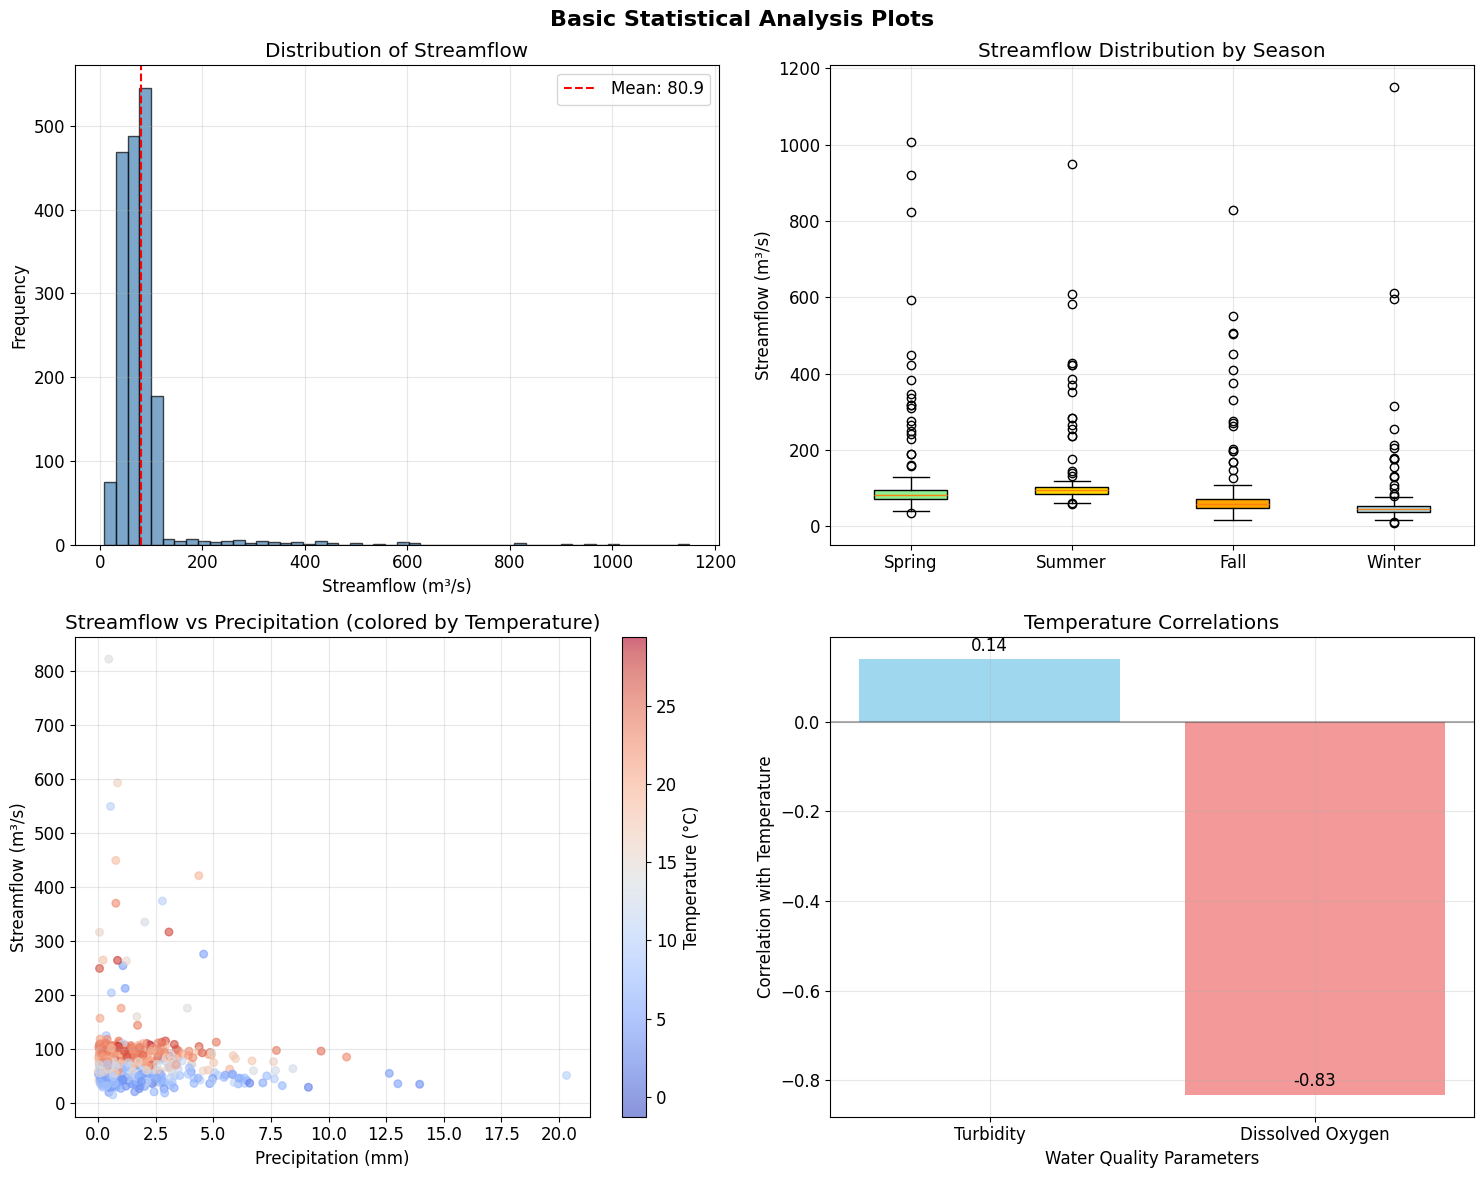

In [9]:
# Create a multi-panel figure for basic statistical plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Basic Statistical Analysis Plots', fontsize=16, fontweight='bold')

# 1. Histogram of Streamflow
ax1 = axes[0, 0]
ax1.hist(hydrology_data['Streamflow_cms'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Streamflow (m³/s)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Streamflow')
ax1.axvline(hydrology_data['Streamflow_cms'].mean(), color='red', linestyle='--', 
           label=f'Mean: {hydrology_data["Streamflow_cms"].mean():.1f}')
ax1.legend()

# 2. Box plot by Season
ax2 = axes[0, 1]
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
streamflow_by_season = [hydrology_data[hydrology_data['Season'] == season]['Streamflow_cms'].values 
                       for season in seasons]
box_plot = ax2.boxplot(streamflow_by_season, labels=seasons, patch_artist=True)
colors = ['lightgreen', 'gold', 'orange', 'lightblue']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Streamflow (m³/s)')
ax2.set_title('Streamflow Distribution by Season')
ax2.grid(True, alpha=0.3)

# 3. Scatter plot: Streamflow vs Precipitation
ax3 = axes[1, 0]
# Only plot days with precipitation > 0
precip_days = hydrology_data[hydrology_data['Precipitation_mm'] > 0]
scatter = ax3.scatter(precip_days['Precipitation_mm'], precip_days['Streamflow_cms'], 
                     c=precip_days['Temperature_C'], cmap='coolwarm', alpha=0.6, s=30)
ax3.set_xlabel('Precipitation (mm)')
ax3.set_ylabel('Streamflow (m³/s)')
ax3.set_title('Streamflow vs Precipitation (colored by Temperature)')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Temperature (°C)')

# 4. Water Quality Correlation Matrix (simplified as bar plot)
ax4 = axes[1, 1]
water_quality_vars = ['Temperature_C', 'Turbidity_NTU', 'DO_mgL']
correlations = hydrology_data[water_quality_vars].corr()['Temperature_C'].drop('Temperature_C')
bars = ax4.bar(range(len(correlations)), correlations.values, 
               color=['skyblue', 'lightcoral'], alpha=0.8)
ax4.set_xlabel('Water Quality Parameters',family='Arial')
ax4.set_ylabel('Correlation with Temperature',family='Arial')
ax4.set_title('Temperature Correlations')
ax4.set_xticks(range(len(correlations)))
ax4.set_xticklabels(['Turbidity', 'Dissolved Oxygen'])
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, correlations.values)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


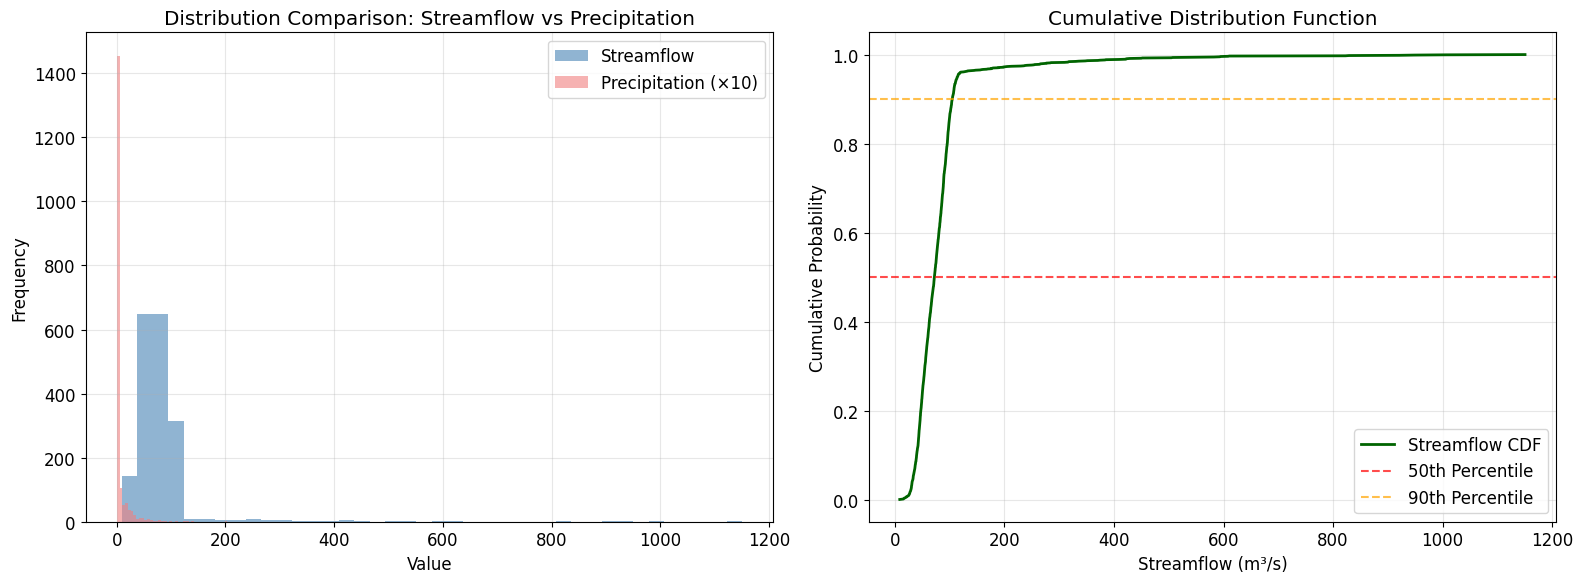

In [5]:
# Advanced histogram with multiple variables
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with multiple variables
ax1.hist(hydrology_data['Streamflow_cms'], bins=40, alpha=0.6, label='Streamflow', color='steelblue')
ax1.hist(hydrology_data['Precipitation_mm'] * 10, bins=40, alpha=0.6, label='Precipitation (×10)', color='lightcoral')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution Comparison: Streamflow vs Precipitation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative distribution function
sorted_flow = np.sort(hydrology_data['Streamflow_cms'])
cumulative_prob = np.arange(1, len(sorted_flow) + 1) / len(sorted_flow)
ax2.plot(sorted_flow, cumulative_prob, linewidth=2, color='darkgreen', label='Streamflow CDF')
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50th Percentile')
ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90th Percentile')
ax2.set_xlabel('Streamflow (m³/s)')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Cumulative Distribution Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Time Series Visualizations

Time series analysis is crucial in hydrology. Let's create beautiful hydrographs and precipitation plots.


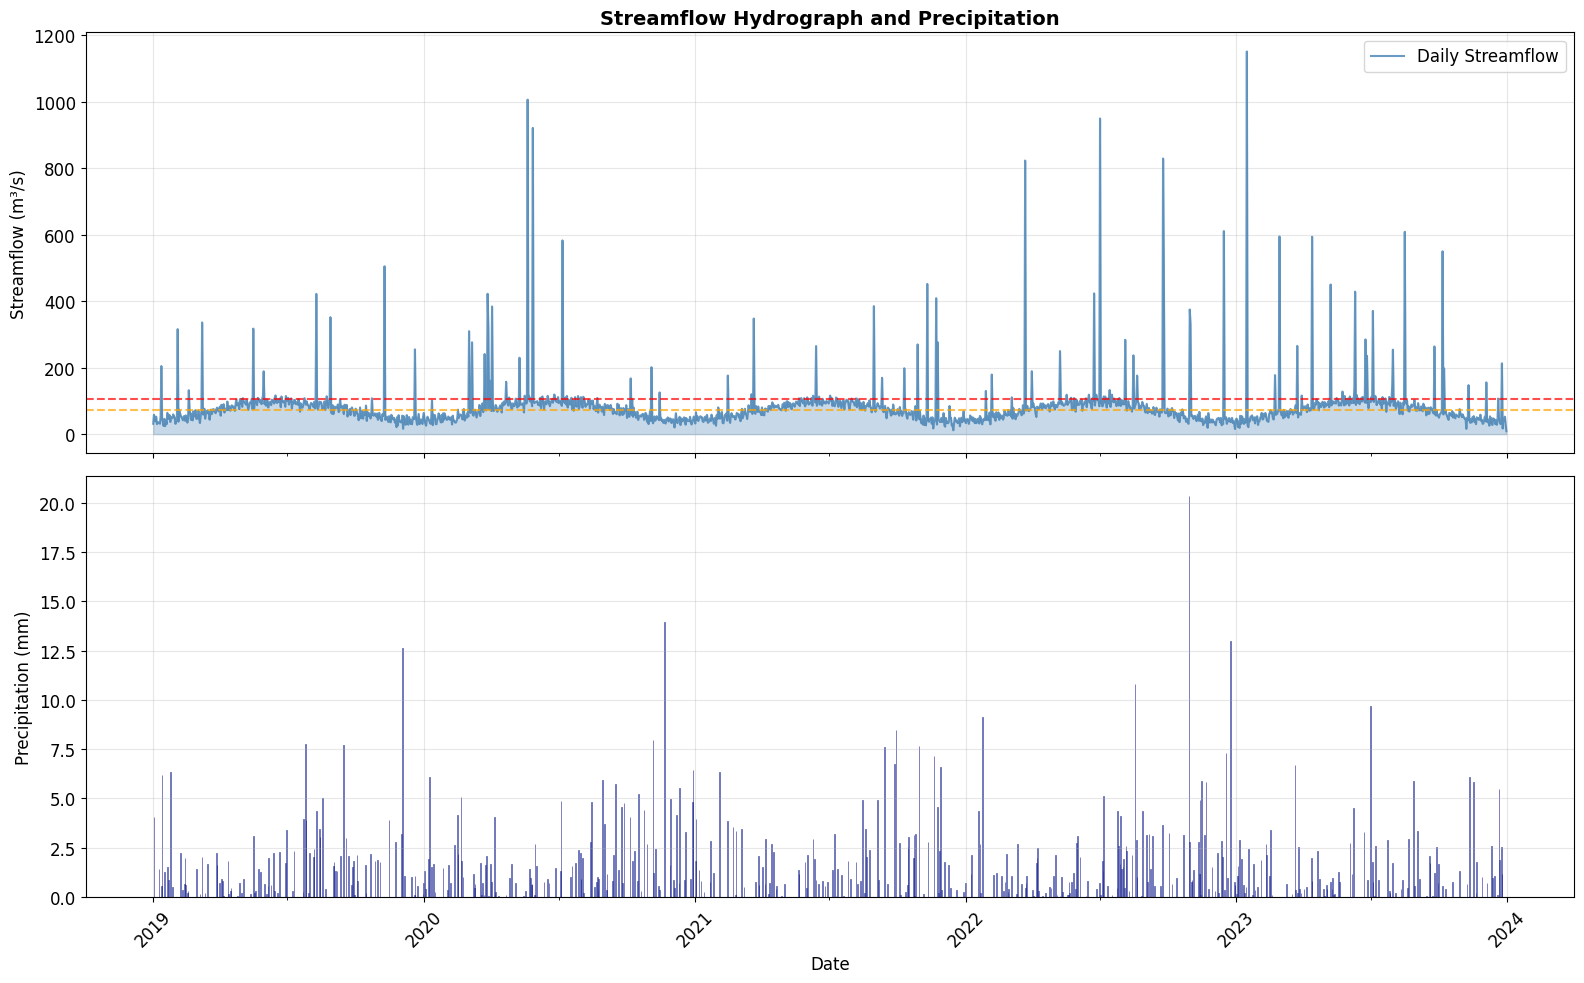

In [6]:
# Create a comprehensive hydrograph with precipitation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Top panel: Streamflow hydrograph
ax1.plot(hydrology_data['Date'], hydrology_data['Streamflow_cms'], 
         linewidth=1.5, color='steelblue', alpha=0.8, label='Daily Streamflow')
ax1.fill_between(hydrology_data['Date'], hydrology_data['Streamflow_cms'], 
                 alpha=0.3, color='steelblue')
ax1.set_ylabel('Streamflow (m³/s)', fontsize=12)
ax1.set_title('Streamflow Hydrograph and Precipitation', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Add flow duration curve information
flow_90th = np.percentile(hydrology_data['Streamflow_cms'], 90)
flow_50th = np.percentile(hydrology_data['Streamflow_cms'], 50)
ax1.axhline(y=flow_90th, color='red', linestyle='--', alpha=0.7, label=f'90th Percentile: {flow_90th:.1f}')
ax1.axhline(y=flow_50th, color='orange', linestyle='--', alpha=0.7, label=f'50th Percentile: {flow_50th:.1f}')

# Bottom panel: Precipitation (bar chart)
precip_data = hydrology_data[hydrology_data['Precipitation_mm'] > 0]
ax2.bar(precip_data['Date'], precip_data['Precipitation_mm'], 
        width=1, color='lightblue', alpha=0.7, edgecolor='navy', linewidth=0.5)
ax2.set_ylabel('Precipitation (mm)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator((1, 7)))

# Rotate x-axis labels
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## Advanced Styling and Customization

Let's explore advanced matplotlib styling techniques to create publication-quality figures.


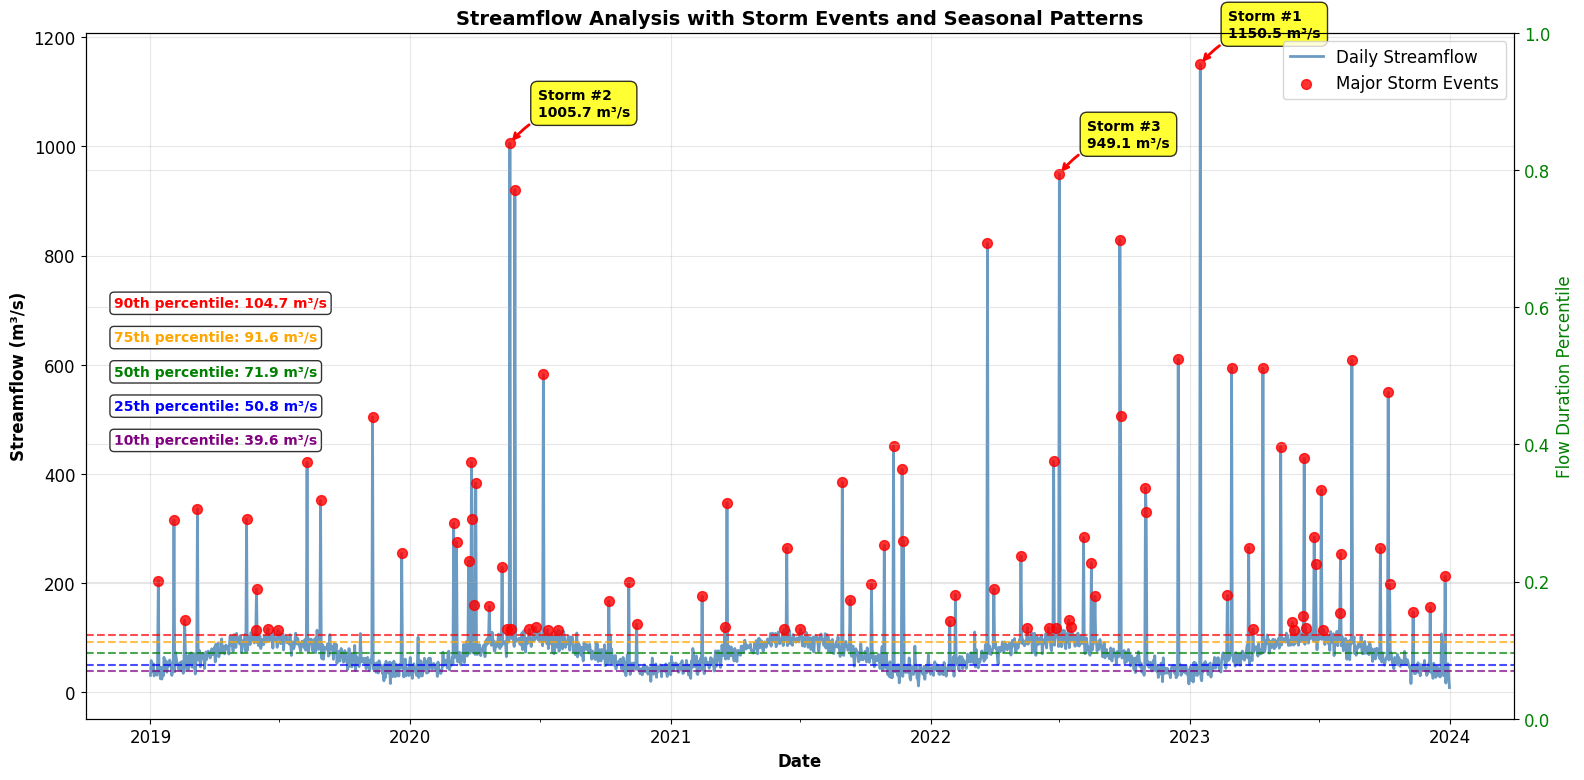

In [7]:
# Create an interactive-style plot with annotations and arrows
fig, ax = plt.subplots(figsize=(16, 8))

# Plot streamflow
ax.plot(hydrology_data['Date'], hydrology_data['Streamflow_cms'], 
        linewidth=2, color='steelblue', alpha=0.8, label='Daily Streamflow')

# Find and highlight major storm events
storm_threshold = np.percentile(hydrology_data['Streamflow_cms'], 95)
storm_events = hydrology_data[hydrology_data['Streamflow_cms'] > storm_threshold]

# Highlight storm events
ax.scatter(storm_events['Date'], storm_events['Streamflow_cms'], 
           color='red', s=50, alpha=0.8, zorder=5, label='Major Storm Events')

# Add annotations for top 3 storm events
top_storms = storm_events.nlargest(3, 'Streamflow_cms')
for i, (idx, storm) in enumerate(top_storms.iterrows()):
    ax.annotate(f'Storm #{i+1}\n{storm["Streamflow_cms"]:.1f} m³/s', 
                xy=(storm['Date'], storm['Streamflow_cms']), 
                xytext=(20, 20), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                              color='red', lw=2))

# Add flow duration curve information
flow_percentiles = [10, 25, 50, 75, 90]
flow_values = [np.percentile(hydrology_data['Streamflow_cms'], p) for p in flow_percentiles]

# Create a secondary y-axis for flow duration
ax2 = ax.twinx()
ax2.set_ylabel('Flow Duration Percentile', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Add percentile lines
colors = ['purple', 'blue', 'green', 'orange', 'red']
for i, (p, val, color) in enumerate(zip(flow_percentiles, flow_values, colors)):
    ax.axhline(y=val, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    ax.text(0.02, .4+i*0.05, f'{p}th percentile: {val:.1f} m³/s', 
            transform=ax.transAxes, fontsize=10, color=color, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Streamflow (m³/s)', fontsize=12, fontweight='bold')
ax.set_title('Streamflow Analysis with Storm Events and Seasonal Patterns', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 7)))

plt.tight_layout()
plt.show()
